In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import parallel_backend
from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#load data
df = pd.read_csv("sentimentdataset.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date
user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),  
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),  
    last_post=("Timestamp", "max")
).reset_index()

user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Active_Hours"].fillna(0, inplace=True)
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

#'addicted' label if more than 2 hours OR 100 interactions
user_daily_activity["Addicted"] = ((user_daily_activity["Daily_Usage_Time"] > 2) | 
                                   (user_daily_activity["Total_Interactions"] > 100)).astype(int)

#merge
df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)

#Encode sentiment
df["sentiment_num"] = pd.factorize(df["Sentiment"])[0]

# --- 3. Prepare features and target ---
X = df[["sentiment_num", "Likes", "Retweets"]]
y = df["Addicted"]

#Parallel Scaling (using Joblib for multi-core CPU usage)
scaler = StandardScaler()
with parallel_backend('threading', n_jobs=-1):
    X_scaled = scaler.fit_transform(X)

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

#neural network!
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#training w/ early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

#evalute
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\nNeural Network Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Epoch 1/50


/var/folders/rv/q52q8kmj0s558xpyhlshtzw00000gn/T/ipykernel_6009/2165098818.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  user_daily_activity["Active_Hours"].fillna(0, inplace=True)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
/Users/kellyg/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7765 - loss: 0.6157 - val_accuracy: 0.8776 - val_loss: 0.5727
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8480 - loss: 0.5429 - val_accuracy: 0.8571 - val_loss: 0.4980
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8500 - loss: 0.4871 - val_accuracy: 0.8265 - val_loss: 0.4409
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8613 - loss: 0.4360 - val_accuracy: 0.8265 - val_loss: 0.3979
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8748 - loss: 0.3877 - val_accuracy: 0.8265 - val_loss: 0.3664
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8699 - loss: 0.3713 - val_accuracy: 0.8265 - val_loss: 0.3441
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8749 - loss: 0.3399 - val_accuracy: 0.8265 - val_loss: 0.3282
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8397 - loss: 0.3774 - val_accuracy: 0.8265 - val_loss: 0.3160
Epoch 9/50
7/7 ━━━

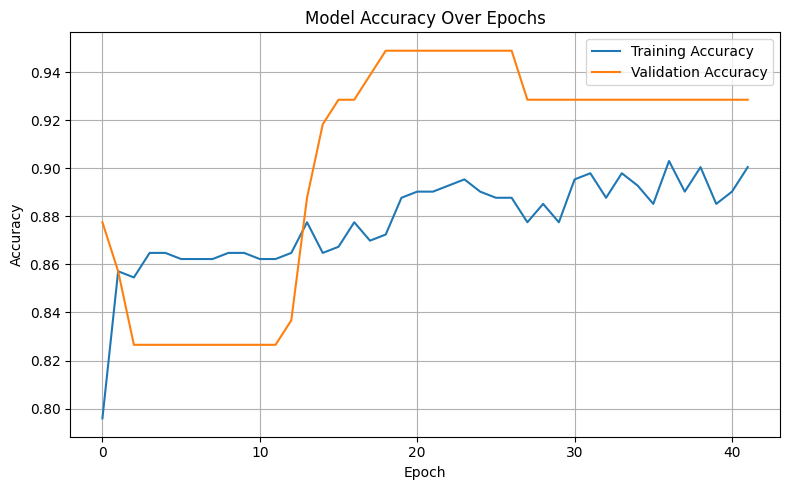

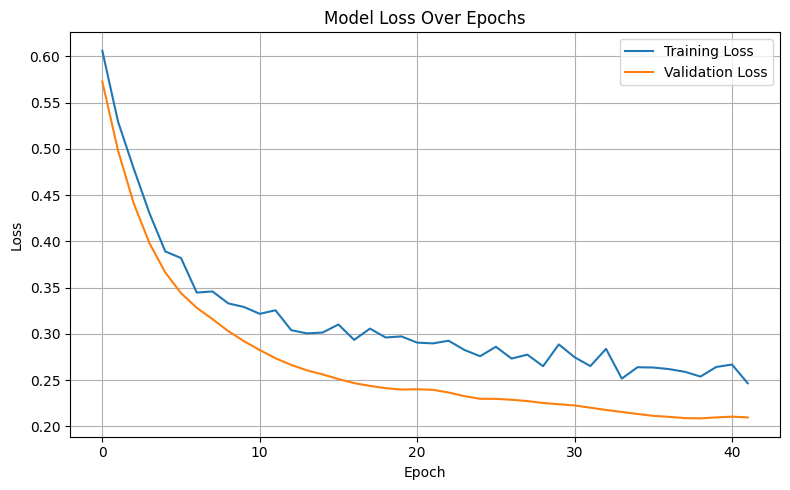

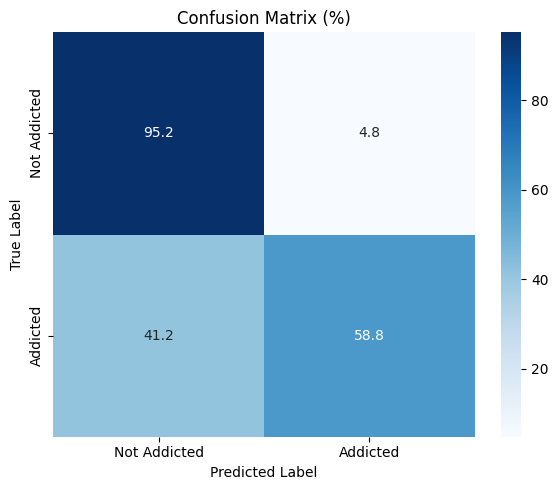

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


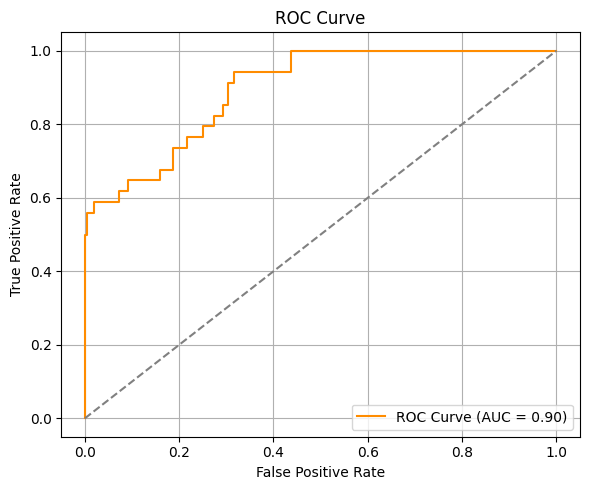

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

#Accuracy (over epochs)
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Loss (over epochs)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Not Addicted', 'Addicted'],
            yticklabels=['Not Addicted', 'Addicted'])
plt.title('Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#ROC
y_proba = model.predict(X_test).ravel()  # get raw probabilities
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Potential issues:**
1. Based on train/val accuracy plot, could be overfitting around epoch 26??
2. About half of addicted users end up labelled as not addicted (FALSE NEGATIVE)